In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
tf.__version__

'2.2.0'

In [0]:
myMinMaxScaler = MinMaxScaler()

In [4]:
import_df = pd.read_csv('20171021_20171124_1min.csv', index_col = 0, date_parser = pd.to_datetime)
import_df

,open,high,low,close,average
timestamp,,,,,
2017-10-21 00:00:00+00:00,6018.7,6022.1,6011.0,6020.0,6016.795301
2017-10-21 00:01:00+00:00,6019.9,6020.0,6014.2,6014.3,6018.435888
2017-10-21 00:02:00+00:00,6014.3,6016.6,6012.1,6012.1,6014.576291
2017-10-21 00:03:00+00:00,6012.1,6014.2,6012.1,6013.0,6012.818012
2017-10-21 00:04:00+00:00,6012.9,6018.0,6012.8,6015.8,6017.010478
...,...,...,...,...,...
2017-11-20 08:42:00+00:00,8053.5,8065.5,8053.5,8061.0,8060.684679
2017-11-20 08:43:00+00:00,8063.5,8063.5,8053.0,8054.0,8058.124414
2017-11-20 08:44:00+00:00,8054.0,8062.0,8053.5,8053.5,8057.491637


In [0]:
import_df = import_df.dropna()

# Train / Test Split

In [6]:
import_df.shape

(43701, 5)

In [7]:
test_size = int(import_df.shape[0] / 3)
train_size = import_df.shape[0] - test_size
train_size

29134

In [0]:
train_df = import_df[:train_size]
# train_df = myMinMaxScaler.fit_transform(train_df)
test_df = import_df[train_size:]
# test_df = myMinMaxScaler.transform(test_df)

# TS Analysis

In [0]:
train_y_orig = train_df.close

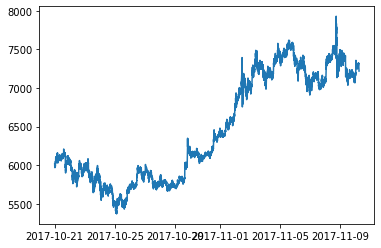

In [10]:
plt.plot(train_y_orig)

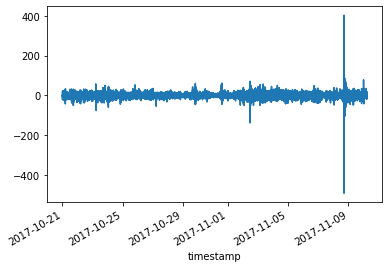

In [11]:
train_y_1dif = (train_y_orig - train_y_orig.shift(1)).dropna()
train_y_1dif.plot();

In [12]:
adfuller(train_y_1dif)

(-24.641323831006986,
 0.0,
 49,
 29083,
 {'1%': -3.4305748694175144,
  '10%': -2.5668229002023737,
  '5%': -2.8616393860891476},
 214252.0801584676)

p-value is 0, therefore reject that the series has unit root, aka series is stationary.

# LSTM


In [13]:
window_size = 30
look_ahead = 1
y_train = np.array(train_df.close[window_size + look_ahead:])
# y_train = np.array(train_df[window_size + look_ahead:, 3])
data_points_train = y_train.shape[0]
data_points_train
y_test = np.array(test_df.close[window_size + look_ahead:])
# y_test = np.array(test_df[window_size + look_ahead:, 3])
data_points_test = y_test.shape[0]
data_points_train, data_points_test

(29103, 14536)

In [0]:
X_train = np.zeros((data_points_train, window_size, 5))
X_test = np.zeros((data_points_test, window_size, 5))

In [0]:
for i in range(data_points_train):
#     X_train[i] = train_df[:window_size,:]
    X_train[i] = train_df.iloc[:window_size,].values
for i in range(data_points_test):   
    X_test[i] = test_df.iloc[:window_size,].values
#     X_test[i] = test_df[:window_size,:]

In [0]:
train_data_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
BATCH_SIZE = 120
BUFFER_SIZE = 10000
train_data_tf = train_data_tf.cache().batch(BATCH_SIZE).repeat()

In [0]:
test_data_tf = tf.data.Dataset.from_tensor_slices((X_test, y_test))
BATCH_SIZE = 120
BUFFER_SIZE = 10000
test_data_tf = test_data_tf.cache().batch(BATCH_SIZE).repeat()

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=X_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='tanh'))

multi_step_model.add(tf.keras.layers.Dense(1))



In [19]:
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            4864      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 16,337
Trainable params: 16,337
Non-trainable params: 0
_________________________________________________________________


In [20]:
for x, y in train_data_tf.take(1):
    print (multi_step_model.predict(x).shape)
    print(multi_step_model.predict(x))

(120, 1)
[[-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 [-0.31063056]
 

In [0]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)

In [0]:
# multi_step_model.compile(optimizer=opt, loss='mse')
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0, lr=0.1), loss='mae')
# multi_step_model.compile(optimizer='adam', loss='mse')

In [23]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:
EVALUATION_INTERVAL = 5_000
EPOCHS = 8


with tf.device('/device:GPU:0'):
    multi_step_history = multi_step_model.fit(train_data_tf, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=test_data_tf,
                                          validation_steps=200)


Epoch 1/8
5000/5000 [==============================] - 45s 9ms/step - loss: 2659.8755 - val_loss: 778.4153
Epoch 2/8
5000/5000 [==============================] - 44s 9ms/step - loss: 622.4038 - val_loss: 684.1541
Epoch 3/8
5000/5000 [==============================] - 44s 9ms/step - loss: 614.2375 - val_loss: 719.3495
Epoch 4/8
5000/5000 [==============================] - 45s 9ms/step - loss: 620.1823 - val_loss: 729.4704
Epoch 5/8
5000/5000 [==============================] - 44s 9ms/step - loss: 617.5226 - val_loss: 674.8962
Epoch 6/8
5000/5000 [==============================] - 44s 9ms/step - loss: 615.3395 - val_loss: 774.1583
Epoch 7/8
5000/5000 [==============================] - 44s 9ms/step - loss: 620.8537 - val_loss: 651.4506
Epoch 8/8
5000/5000 [==============================] - 44s 9ms/step - loss: 611.0631 - val_loss: 757.1682


In [0]:
STEP = 1
def create_time_steps(length):
      return list(range(-length, 0))
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = 1

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


In [26]:
# dir(multi_step_model)
# dir(multi_step_model.weights[0][0])
# # multi_step_model.weights[1].numpy().min()
# len(multi_step_model.weights)
# for i in range(8):
#     print(multi_step_model.weights[i].numpy().min())
# multi_step_model.weights
dir(test_data_tf)

['_GeneratorState',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_count',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_depende

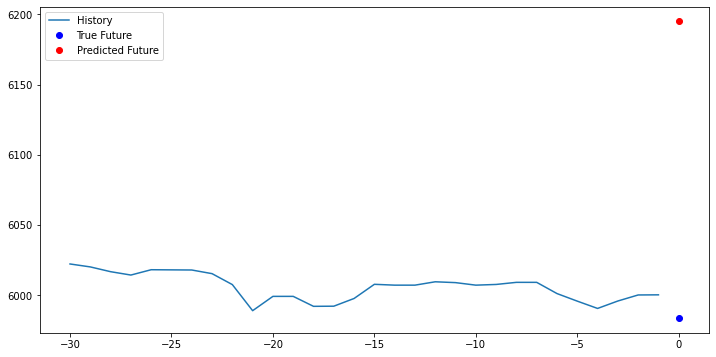

In [27]:
for x, y in train_data_tf.take(1):
      multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0]);

In [28]:
for x, y in test_data_tf.take(1):
  print(multi_step_model.predict(x))

[[6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [6194.984]
 [61

In [30]:
multi_step_model.save('my_model') 

INFO:tensorflow:Assets written to: my_model/assets


In [36]:
import os
print( os.getcwd() )
print( os.listdir('my_model') )

/content
['saved_model.pb', 'assets', 'variables']


In [42]:
!zip -r model.zip my_model

  adding: my_model/ (stored 0%)
  adding: my_model/saved_model.pb (deflated 90%)
  adding: my_model/assets/ (stored 0%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.index (deflated 66%)
  adding: my_model/variables/variables.data-00000-of-00002 (deflated 78%)
  adding: my_model/variables/variables.data-00001-of-00002 (deflated 54%)
